## Libraries to import

In [6]:
!pip install tensorflow
!pip install -q -U keras-tuner

In [7]:
from google.colab import drive
drive.mount('/content/drive')
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
import keras_tuner as kt

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Importing the dataset

In [8]:
all_prices = pd.read_csv('/content/drive/MyDrive/ml-datasets/currencies_prediction/prices_1d.csv')

### Feature engineering

In [9]:
# adding features that make more sense than raw data
# all_prices["Gold_ret"] = all_prices["Gold"].pct_change()
# all_prices["Silver_ret"] = all_prices["Silver"].pct_change()
# all_prices["CAD_ret"] = all_prices["CAD"].pct_change()

# all_prices["Gold_ma"] = all_prices["Gold"].rolling(5).mean()
# all_prices["Silver_ma"] = all_prices["Silver"].rolling(5).mean()
# all_prices["CAD_ma"] = all_prices["CAD"].rolling(5).mean()

In [10]:
all_prices = all_prices.dropna().drop(columns=['Date'])

In [11]:
all_prices.head()

,Gold,Silver,CAD
0,376.600006,5.255,0.734484
1,381.799988,5.282,0.742280
2,387.200012,5.265,0.738443
3,385.899994,5.235,0.737953
4,387.500000,5.302,0.740686


In [12]:
all_prices.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5790 entries, 0 to 5789
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Gold    5790 non-null   float64
 1   Silver  5790 non-null   float64
 2   CAD     5790 non-null   float64
dtypes: float64(3)
memory usage: 135.8 KB


In [13]:
all_prices.describe()

,Gold,Silver,CAD
count,5790.000000,5790.000000,5790.000000
mean,1366.476683,19.576687,0.837469
std,656.805829,8.407813,0.100378
min,369.200012,4.810000,0.679486
25%,937.050003,14.400750,0.753807
50%,1288.649963,17.690001,0.798454
75%,1729.574982,24.262250,0.935487
max,4336.399902,53.332001,1.088495


In [14]:
scaler = MinMaxScaler()
scaled = scaler.fit_transform(all_prices)
scaled

array([[0.00186529, 0.0091711 , 0.13446592],
       [0.00317604, 0.00972755, 0.15352722],
       [0.00453721, 0.00937719, 0.14414631],
       ...,
       [0.93836963, 0.93740978, 0.07242604],
       [0.93836963, 0.93740978, 0.08016895],
       [0.93836963, 0.93740978, 0.08184498]])

In [15]:
def create_sequences(data, timesteps):
    X, y = [], []
    for i in range(len(data) - timesteps):
        X.append(data[i : i + timesteps])
        y.append(data[i + timesteps])
    return np.array(X), np.array(y)

In [16]:
max_window = 60

X, y = create_sequences(scaled, max_window)
X.shape

(5730, 60, 3)

### Train/test split

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, shuffle=False)

## GRU implementation

### Hyperparameter tuning

In [18]:
def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_true - y_pred)))

def mae(y_true, y_pred):
    return tf.reduce_mean(tf.abs(y_true - y_pred))

def mape(y_true, y_pred):
    return tf.reduce_mean(tf.abs((y_true - y_pred) / (y_true + 1e-8))) * 100

In [19]:
def model_builder(hp):
    model = keras.Sequential([
        keras.layers.GRU(
            units=hp.Int("units_1", min_value=16, max_value=128, step=16),
            return_sequences=True,
            input_shape=(hp.Int("window", min_value=10, max_value=100, step=10), 3),
            kernel_regularizer=keras.regularizers.l2(hp.Choice("l2_reg", values=[1e-6, 1e-5, 1e-4]))
        ),
        keras.layers.Dropout(hp.Float("dropout_1", min_value=0.1, max_value=0.3, step=0.05)),
        keras.layers.GRU(
            units=hp.Int("units_2", min_value=8, max_value=64, step=8),
            return_sequences=False,
            kernel_regularizer=keras.regularizers.l2(hp.Choice("l2_reg2", [1e-6, 1e-5, 1e-4])),
        ),
        keras.layers.Dropout(hp.Float("dropout_2", min_value=0.1, max_value=0.3, step=0.05)),
        keras.layers.Dense(3, activation="relu") #output
    ])

    model.compile(
        optimizer=keras.optimizers.Adam(hp.Choice("learning_rate", [1e-2, 5e-3, 1e-3, 5e-4, 1e-4])),\
        loss="mse",
        metrics=[rmse, mae, mape]
    )

    return model

In [20]:
tuner = kt.Hyperband(
    model_builder,
    objective=kt.Objective("val_rmse", direction="min"),
    max_epochs=40,
    max_consecutive_failed_trials=5,
    seed=42,
    directory="tuning_results",
    project_name="gold_silver_cad",
)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [21]:
stop_early = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5
)

In [22]:
tuner.search(x=X_train, y=y_train, validation_split=0.15, callbacks=[stop_early])

Trial 90 Complete [00h 00m 53s]
val_rmse: 0.012734148651361465

Best val_rmse So Far: 0.009476613253355026
Total elapsed time: 00h 41m 17s


### Metrics evaluation of the best model

In [24]:
best_model = tuner.get_best_models(1)[0]
best_model.save('gru_1d.keras')
best_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 50, 112)        │        39,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 50, 112)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 48)             │        23,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 48)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 3)              │           147 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 62,787 (245.26 KB)

 Trainable params: 62,787 (245.26 KB)

 Non-trainable params: 0 (0.00 B)

In [25]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
best_hps.values

{'units_1': 112,
 'window': 50,
 'l2_reg': 1e-05,
 'dropout_1': 0.2,
 'units_2': 48,
 'l2_reg2': 1e-06,
 'dropout_2': 0.1,
 'learning_rate': 0.01,
 'tuner/epochs': 40,
 'tuner/initial_epoch': 0,
 'tuner/bracket': 0,
 'tuner/round': 0}

In [26]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

model = best_model

y_pred = model.predict(X_test)

y_pred_inv = scaler.inverse_transform(y_pred)
y_test_inv = scaler.inverse_transform(y_test)

rmse_val = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
mae_val  = mean_absolute_error(y_test_inv, y_pred_inv)
mape_val = mean_absolute_percentage_error(y_test_inv, y_pred_inv)

print("RMSE:", rmse_val)
print("MAE :", mae_val)
print("MAPE:", mape_val)

27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
RMSE: 36.769723474684376
MAE : 13.620253392661267
MAPE: 0.0116326478244101


In [27]:
baseline = scaler.inverse_transform(X_test[:, -1, :])

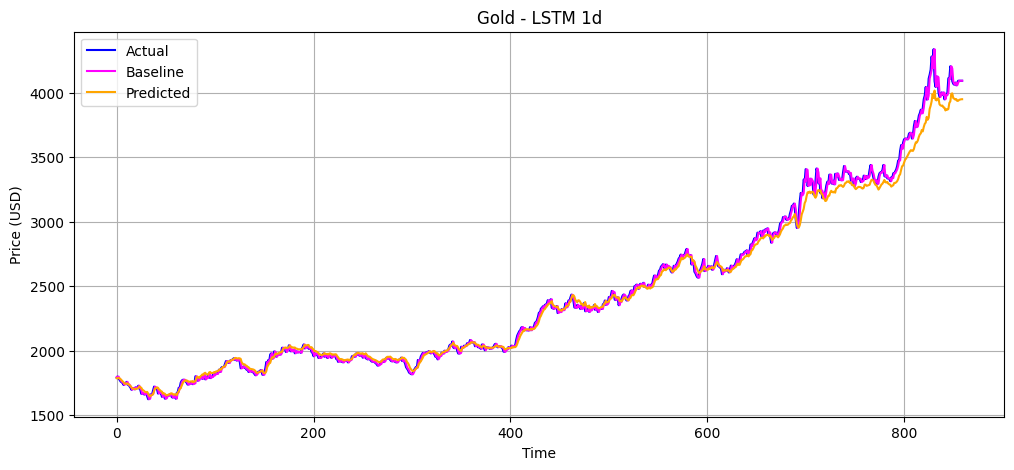

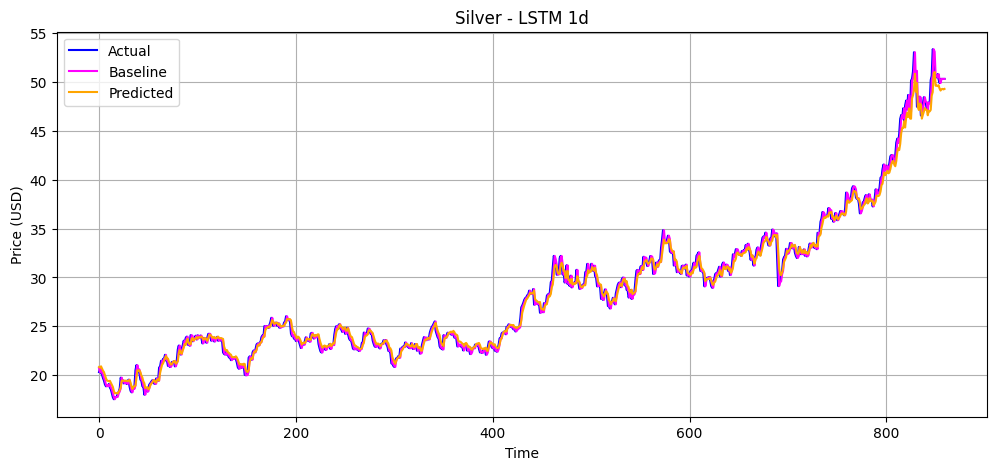

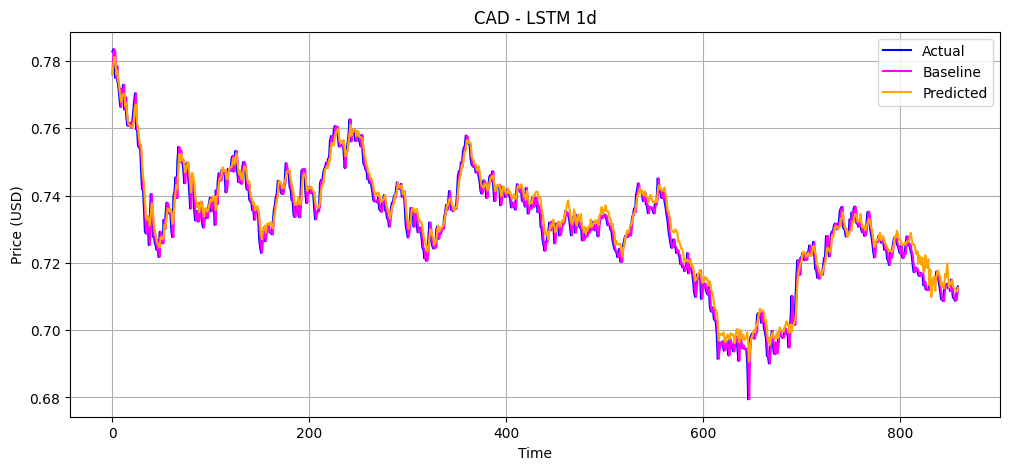

In [30]:
def plot_asset(i, asset_name):
    plt.figure(figsize=(12,5))
    plt.plot(y_test_inv[:, i], label="Actual", color="blue")
    plt.plot(baseline[:, i], label="Baseline", color="magenta")
    plt.plot(y_pred_inv[:, i], label="Predicted", color="orange")
    plt.title(f"{asset_name} - GRU 1d")
    plt.xlabel("Time")
    plt.ylabel("Price (USD)")
    plt.legend()
    plt.grid(True)
    plt.show()

plot_asset(0, "Gold")
plot_asset(1, "Silver")
plot_asset(2, "CAD")

In [29]:
def mae(y, p): return np.mean(np.abs(y-p))
def rmse(y, p): return np.sqrt(np.mean((y-p)**2))
def mape(y, p): return np.mean(np.abs((y-p)/y))*100

assets = ["Gold","Silver","CAD"]
for i in range(3):
    print(assets[i])
    print(" MAE :", mae(y_test_inv[:,i], y_pred_inv[:,i]))
    print(" RMSE:", rmse(y_test_inv[:,i], y_pred_inv[:,i]))
    print(" MAPE:", mape(y_test_inv[:,i], y_pred_inv[:,i]))
    print()

Gold
 MAE : 40.36816704328671
 RMSE: 63.68321163626411
 MAPE: 1.4360407772648793

Silver
 MAE : 0.4899314747300255
 RMSE: 0.6973073875131008
 MAPE: 1.6884384104087324

CAD
 MAE : 0.0026616599670676298
 RMSE: 0.003363388099455669
 MAPE: 0.365315159649419



### Retrain a model with best HPs 10 times

To ensure the model did not randomly achieve good results with the test set

In [ ]:
mae_arr = []
rmse_arr = []
mape_arr = []

for i in range(10):

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, shuffle=False)

  model = keras.Sequential([
      keras.layers.GRU(
          units=best_hps.values["units_1"],
          return_sequences=True,
          input_shape=(best_hps.values["window"], 3),
          kernel_regularizer=best_hps.values["l2_reg"]
      ),
      keras.layers.Dropout(best_hps.values["dropout_1"]),
      keras.layers.GRU(
          units=best_hps.values["units_2"],
          return_sequences=False,
          kernel_regularizer=best_hps.values["l2_reg"],
      ),
      keras.layers.Dropout(best_hps.values["dropout_2"]),
      keras.layers.Dense(3, activation="relu") #output
  ])

  model.compile(
      optimizer=keras.optimizers.Adam(best_hps.values["learning_rate"]),
      loss='mse',
      metrics=[rmse, mae, mape]
  )

  model.fit(X_train, y_train, epochs=best_hps.values['tuner/epochs'])

  y_pred = model.predict(X_test)

  y_pred_inv = scaler.inverse_transform(y_pred)
  y_test_inv = scaler.inverse_transform(y_test)

  rmse_val = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
  mae_val  = mean_absolute_error(y_test_inv, y_pred_inv)
  mape_val = mean_absolute_percentage_error(y_test_inv, y_pred_inv)

  print("RMSE:", rmse_val)
  print("MAE :", mae_val)
  print("MAPE:", mape_val)